Using space navigation v2 environment test these algorithms: DQN, PPO, A2C

In [1]:
# Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import BaseCallback

from Environment_Creator import env_creator, Environments_enum

In [23]:
# Fetch environment
def make_navigation_env():
    return env_creator(Environments_enum.Navigation_v2.value)

# Register and make environment
gym.register(id="SpaceNavigation_v0", entry_point=make_navigation_env)
env = gym.make("SpaceNavigation_v0")

C:\Users\zhech\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment SpaceNavigation_v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
'''
class MultiAlgorithmRewardLogger(BaseCallback):
    def __init__(self, algo_name):
        super().__init__()
        self.algo_name = algo_name  # Store algorithm name
        self.episode_rewards = []   # Store rewards for each episode
        self.current_episode_reward = 0  # Track reward within an episode

    def _on_step(self) -> bool:
        # Extract reward from current step
        reward = self.locals["rewards"]
        self.current_episode_reward += reward

        # Check if episode is done
        if self.locals["dones"]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for the next episode
        return True
'''

In [41]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class MultiAlgorithmRewardLogger(BaseCallback):
    def __init__(self, algo_name):
        super().__init__()
        self.algo_name = algo_name
        self.episode_rewards = []  # Tracking total reward per episode
        self.episode_lengths = []  # Tracks how long each episode lasts
        self.losses = []  # Tracks loss values for PPO/A2C
        self.entropies = []  # Entropy tracking for exploration
        self.values = []  # Value function estimates
        self.exploration_rates = []  # DQN-specific tracking

        self.current_episode_reward = 0  # Keeps track of current episode reward
        self.current_episode_length = 0  # Keeps track of current episode length

    def _on_step(self) -> bool:
        """Logs rewards and additional metrics at each step"""
    
        # Track rewards
        reward = self.locals["rewards"]
        self.current_episode_reward += reward
        self.current_episode_length += 1  # Track episode length
    
        # Check and append loss if it exists
        if "loss" in self.locals and isinstance(self.locals["loss"], (float, int)):
            self.losses.append(self.locals["loss"])
    
        # Check and append entropy if it exists
        if "entropy" in self.locals and isinstance(self.locals["entropy"], (float, int)):
            self.entropies.append(self.locals["entropy"])
    
        # FIX: Ensure `values` is a valid numerical array before computing mean
        if "values" in self.locals and isinstance(self.locals["values"], (list, np.ndarray)):
            if len(self.locals["values"]) > 0:  # Ensure it's not empty
                self.values.append(np.mean(self.locals["values"]))
            else:
                self.values.append(0)  # Default to 0 if empty
        else:
            self.values.append(0)  # Default to 0 if `values` is missing or invalid
    
        # Track exploration rate for DQN
        if isinstance(self.model, DQN) and hasattr(self.model, "exploration_rate"):
            self.exploration_rates.append(self.model.exploration_rate)
    
        # When episode ends, store rewards and reset counters
        if self.locals["dones"]:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
    
            # Reset episode-specific counters
            self.current_episode_reward = 0
            self.current_episode_length = 0
    
        return True  # Continue training

reward_logger_ppo = MultiAlgorithmRewardLogger("PPO")
reward_logger_dqn = MultiAlgorithmRewardLogger("DQN")
reward_logger_a2c = MultiAlgorithmRewardLogger("A2C")

reward_loggers = [reward_logger_ppo, reward_logger_dqn, reward_logger_a2c]

In [42]:
# Smaller network for testing purposes
# policy_kwargs=dict(net_arch=[64, 64]),  # Smaller network

In [56]:
# Configure model selection function
def set_model(algo, policy):
    '''
        Selects a model algorithm: DQN, PPO, A2C. Model will be configured and ready for training.
        Args:
            algo: input algorithm as str: DQN, PPO, A2C
            policy: input policy as str: MlpPolicy, etc... 
        Returns:
            stable baselines3 model
    '''
    match algo:
        case "DQN":
            model = DQN(
                policy,
                env,
                learning_rate=5e-4,  # Learning rate for better convergence
                buffer_size=5000,  # Replay buffer size [tested: 10000]
                learning_starts=500,  # Number of steps before training starts
                batch_size=32,  # Mini-batch size for training [tested: 16, 128]
                gamma=0.95,  # Discount factor for future rewards
                target_update_interval=500,  # How often to update target network [tested: 500]
                train_freq=5,  # Train every n steps [tested: 10]
                exploration_fraction=0.3,  # Explore more in the beginning
                verbose=1,
                tensorboard_log="./logs",  # Logging
                device='cuda',
                policy_kwargs = dict(
                    net_arch=[128, 128],  # More neurons per layer
                    dueling=True,  # Enables Dueling DQN (improves stability)
                )
            )
        case "PPO":
            model = PPO(
                policy,
                env, 
                learning_rate=1e-4,  # Lower LR for stable updates in physics-based problems
                n_steps=1024,  # Larger batch size helps smooth policy updates [tested: 2048]
                batch_size=32,  # Batch size large for better stability [tested: 16, 256]
                n_epochs=10,  # More updates per batch (stabilizes training)
                gamma=0.999,  # High discount factor for long-term rewards
                gae_lambda=0.95,  # Generalized Advantage Estimation (smooths advantage estimation)
                clip_range=0.2,  # Standard PPO clipping
                ent_coef=0.01,  # Encourage some exploration
                vf_coef=0.5,  # Balance between policy and value function loss
                max_grad_norm=0.5,  # Prevent exploding gradients
                target_kl=0.05,  # Prevent large policy updates (for stable training) [tested with 0.02 - updated to handle larger updates due to early stopping]
                tensorboard_log="./logs",  # Logging
                verbose=1,
                device='cuda',  # Use GPU if available
                policy_kwargs = dict(
                    net_arch=[128, 128, 64],  # Three-layer architecture
                    activation_fn=nn.ReLU,
                )
            )
        case "A2C":
            model = A2C(
                policy=policy,
                env=env,
                learning_rate=3e-4,
                n_steps=10,  # Default value, increase this to match batch size preferences [tested: 5, 3]
                gamma=0.99,  # From the table
                gae_lambda=1.0,  # From the table, helps with Generalized Advantage Estimation
                ent_coef=0.01,  # From the table, controls entropy for exploration
                vf_coef=0.5,  # From the table, balance between policy and value function
                max_grad_norm=0.5,  # From the table, limits gradient explosion
                rms_prop_eps=1e-5,  # Default value for RMSProp, stability for gradient updates
                use_rms_prop=True,  # Using RMSProp for stable optimization
                use_sde=False,  # Enable for stochastic networks [tested with False (should improve exploration eff)]
                sde_sample_freq=-1,  # Only relevant if use_sde=True
                normalize_advantage=False,  # Keep advantage normalization as False unless needed
                stats_window_size=100,  # The size of the window for stats tracking
                tensorboard_log="./logs",  # TensorBoard logs
                verbose=1,
                seed=None,  # Set a seed for reproducibility if desired
                device='auto',  # Automatically selects the device (CPU or GPU)
                _init_setup_model=True,  # Initialize model setup
                policy_kwargs = dict(
                    net_arch=dict(
                        pi=[128, 128],  # Policy network (actor)
                        vf=[128, 128],  # Value function network (critic)
                    ),
                    activation_fn=nn.ReLU,
                )  
            )
        case _:
            raise ValueError(f"Unknown algorithm type: {algo}")

    return model

In [44]:
# Set the models to a collection
models = []
models.append(set_model("PPO", "MlpPolicy"))
models.append(set_model("DQN", "MlpPolicy"))
models.append(set_model("A2C", "MlpPolicy"))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [57]:
iter = 0
# Train and save
for model, logger in zip(models, reward_loggers):
    iter = iter + 1

    # Log training progress
    # log_dir = "./logs"
    # new_logger = configure(log_dir, ["stdout", "tensorboard"])
    # model.set_logger(new_logger)
    
    model.learn(
        total_timesteps=100_000,
        log_interval=100,
        reset_num_timesteps=False, # for continual training
        progress_bar=False,
        callback=logger
    )
    model.save(f"spacenavigation_comp_{iter}")

Logging to ./logs\PPO_1
Logging to ./logs\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.1     |
|    ep_rew_mean      | 4.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16000    |
|    fps              | 1011     |
|    time_elapsed     | 2        |
|    total_timesteps  | 652805   |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 1.39     |
|    n_updates        | 130460   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.3     |
|    ep_rew_mean      | 5.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16100    |
|    fps              | 1003     |
|    time_elapsed     | 5        |
|    total_timesteps  | 655934   |
| train/              |          |
|    learning_rate    | 0.0005   |
|    lo

In [58]:
# Load a Model for Continued Training and reattach the reward logger
# models = []
loggers = [reward_logger_ppo, reward_logger_dqn, reward_logger_a2c]
algo_names = ["PPO", "DQN", "A2C"]

# Load each saved model
for i, algo in enumerate(algo_names, start=1):
    model_path = f"spacenavigation_comp_{i}.zip"
    
    if algo == "PPO":
        model = PPO.load(model_path, env=env)
    elif algo == "DQN":
        model = DQN.load(model_path, env=env)
    elif algo == "A2C":
        model = A2C.load(model_path, env=env)

    # Attach the correct logger
    reward_logger = loggers[i - 1]
    
    # Continue training with logger attached
    model.learn(
        total_timesteps=100_000,
        reset_num_timesteps=False,  # Continue training without resetting
        log_interval=100,
        callback=reward_logger,  # Reattach logger
        progress_bar=False
    )

    # Save again after additional training
    model.save(f"spacenavigation_comp_{i}_updated")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs\PPO_1
Early stopping at step 8 due to reaching max kl: 0.09
Early stopping at step 9 due to reaching max kl: 0.09
Early stopping at step 1 due to reaching max kl: 0.08
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | -2.01    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19000    |
|    fps              | 986      |
|    time_elapsed     | 3        |
|    total_timesteps  | 753132   |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.757    |
|    n_updates        | 150526   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.3     |
|    e

In [59]:
rewards_PPO = []
rewards_DQN = []
rewards_A2C = []

# Define function to evaluate the model
def evaluate_model(model, env, num_episodes=50):
    """
    Runs the model on the environment for a fixed number of episodes 
    and records rewards.

    Returns:
        rewards_per_episode: List of total rewards per episode
    """
    rewards_per_episode = []

    for _ in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            if str(model.__class__.__name__) == "PPO":
                rewards_PPO.append(reward)
            if str(model.__class__.__name__) == "DQN":
                rewards_DQN.append(reward)
            if str(model.__class__.__name__) == "A2C":
                rewards_A2C.append(reward)
                
            done = done or truncated
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return np.array(rewards_per_episode).tolist()

# Evaluate each trained model
num_eval_episodes = 50
eval_results = {}

for i, model in enumerate(models):
    model = model.load(f"spacenavigation_comp_{i + 1}_updated")
    algo = str(model.__class__.__name__)  # Ensure it's a string
    rewards = evaluate_model(model, env, num_eval_episodes)
    
    print(f"Evaluating {algo}, Reward shape: {np.shape(rewards)}")  # Debugging output
    
    eval_results[algo] = rewards  # Store properly formatted rewards

# Print summary statistics
for algo, rewards in eval_results.items():
    print(f"{algo} - Mean Reward: {np.mean(rewards):.2f}, Std Dev: {np.std(rewards):.2f}")

Evaluating PPO, Reward shape: (50,)
Evaluating DQN, Reward shape: (50,)
Evaluating A2C, Reward shape: (50,)
PPO - Mean Reward: -56.60, Std Dev: 0.00
DQN - Mean Reward: 12.30, Std Dev: 0.00
A2C - Mean Reward: -82.31, Std Dev: 0.00


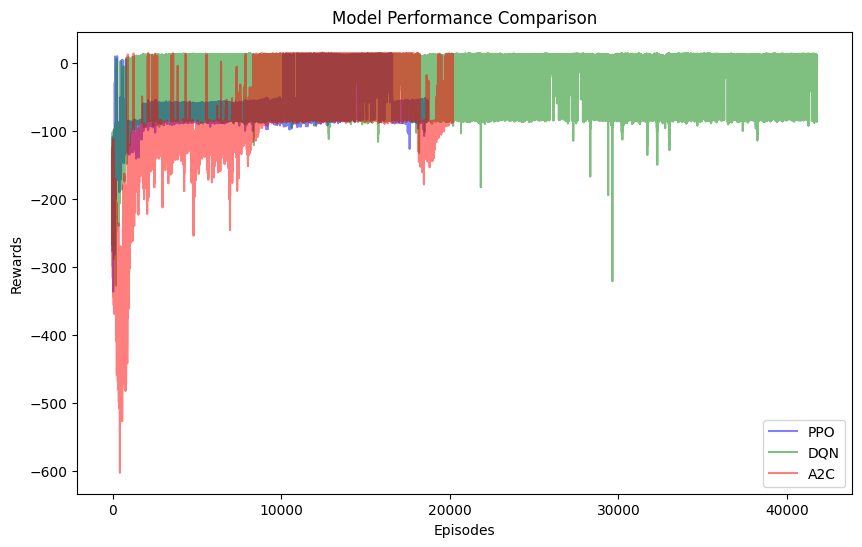

In [64]:
rewards_PPO = np.array(rewards_PPO)
rewards_DQN = np.array(rewards_DQN)
rewards_A2C = np.array(rewards_A2C)

plt.figure(figsize=(10, 6))

# Plot each model's rewards
plt.plot(rewards_PPO, label='PPO', color='blue', alpha=0.5)
plt.plot(rewards_DQN, label='DQN', color='green', alpha=0.5)
plt.plot(rewards_A2C, label='A2C', color='red', alpha=0.5)

# Add titles and labels
plt.title('Model Performance Comparison')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()

# Show plot
plt.show()

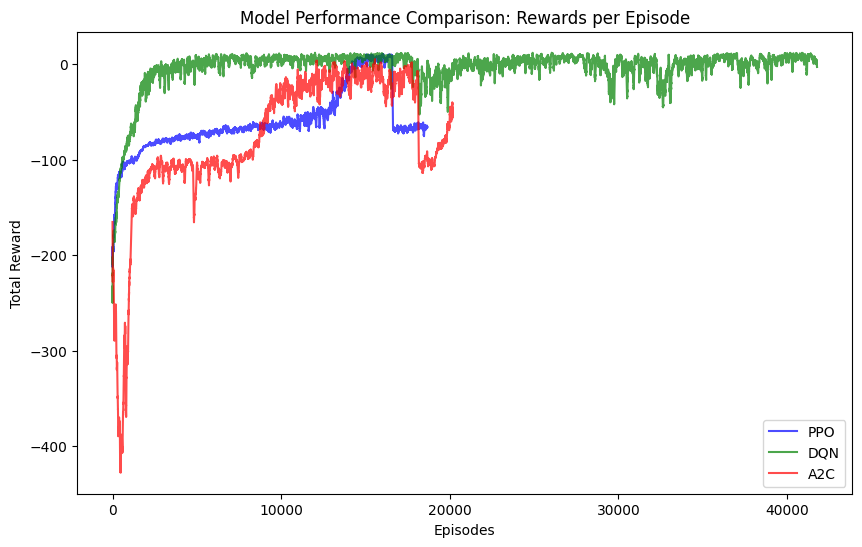

In [61]:
# Convert lists to NumPy arrays for better plotting
rewards_PPO = np.array(reward_logger_ppo.episode_rewards)
rewards_DQN = np.array(reward_logger_dqn.episode_rewards)
rewards_A2C = np.array(reward_logger_a2c.episode_rewards)

def smooth(y, window_size=50):
    return pd.Series(y).rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(10, 6))

# Plot rewards for each model with different colors
plt.plot(smooth(rewards_PPO.flatten()), label="PPO", color="blue", alpha=0.7)
plt.plot(smooth(rewards_DQN.flatten()), label="DQN", color="green", alpha=0.7)
plt.plot(smooth(rewards_A2C.flatten()), label="A2C", color="red", alpha=0.7)

# Labels and Title
plt.title("Model Performance Comparison: Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()

# Show the plot
plt.show()

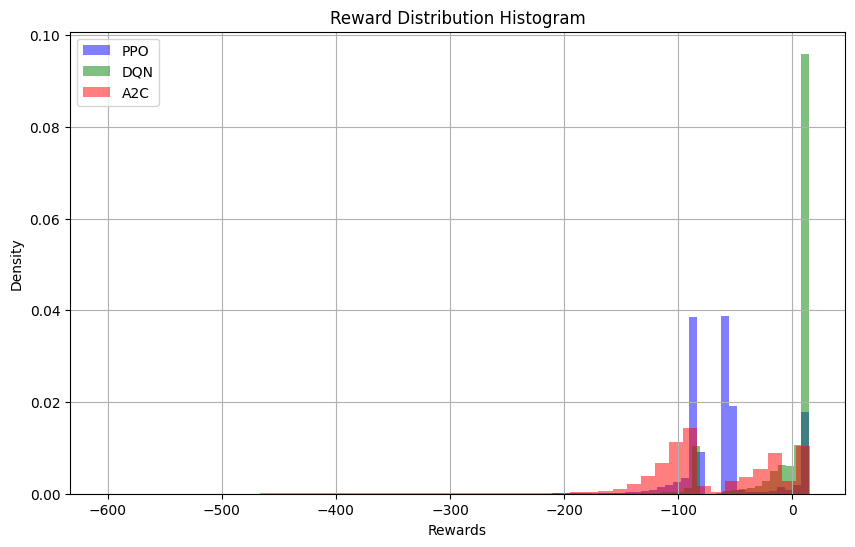

In [62]:
plt.figure(figsize=(10, 6))

plt.hist(rewards_PPO, bins=50, alpha=0.5, label="PPO", color="blue", density=True)
plt.hist(rewards_DQN, bins=50, alpha=0.5, label="DQN", color="green", density=True)
plt.hist(rewards_A2C, bins=50, alpha=0.5, label="A2C", color="red", density=True)

plt.xlabel("Rewards")
plt.ylabel("Density")
plt.title("Reward Distribution Histogram")
plt.legend()
plt.grid(True)
plt.show()

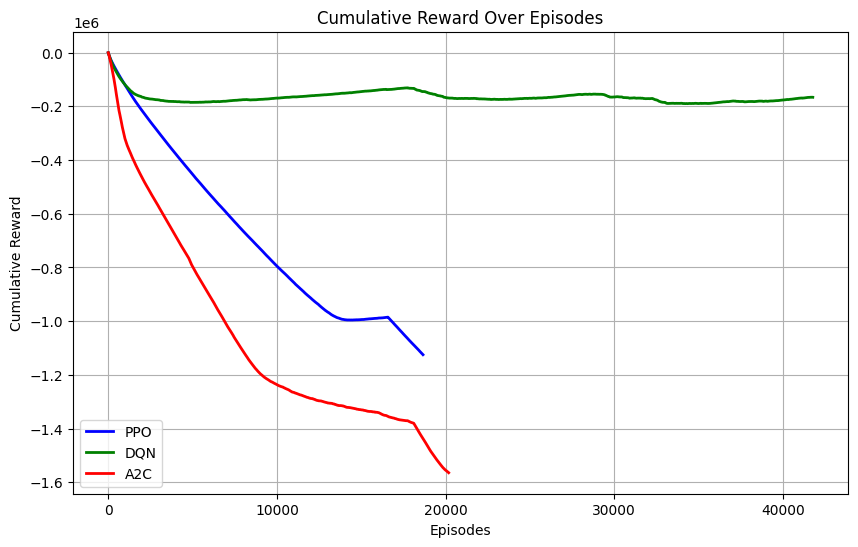

In [63]:
cumulative_rewards_PPO = np.cumsum(rewards_PPO)
cumulative_rewards_DQN = np.cumsum(rewards_DQN)
cumulative_rewards_A2C = np.cumsum(rewards_A2C)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards_PPO, label="PPO", color="blue", linewidth=2)
plt.plot(cumulative_rewards_DQN, label="DQN", color="green", linewidth=2)
plt.plot(cumulative_rewards_A2C, label="A2C", color="red", linewidth=2)

plt.title("Cumulative Reward Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()